In [1]:
import argparse
import datetime
import math
import os
import sys
import random
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
sys.path.append('/data2/youngju/kimst24')

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split  
from torchvision import datasets, models, transforms
from tqdm.auto import tqdm
from utils.load_dataset import get_CUB_loaders
from utils.config_funcs import *
from utils.visualization import *

/home/youngju/anaconda3/envs/proto/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--data-path", type=str, default="/data/CUB_200_2011/images")
parser.add_argument("--model-path", type=str, default="/data2/youngju/kimst24/outputs_backup/clf_checkpoints/2024-05-01_204226/clf_ep-24_lr-0.001_val-acc-0.7630.pth")
parser.add_argument("--pickle-path", type=str, default="/data2/youngju/kimst24/outputs/get_config/train")
parser.add_argument("--q_pickle-path", type=str, default="/data2/youngju/kimst24/outputs/get_config/test")
parser.add_argument("--seed", type=int, default=0)
parser.add_argument("--batch-size", type=int, default=512)
parser.add_argument("--num-pickle", type=int, default=7)
parser.add_argument("--device", type=str, default="cuda:5")
parser.add_argument("--train-ratio", type=float, default=0.7)

args = parser.parse_args(args=[])

In [3]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

random.seed(args.seed)
torch.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False

# (train_loader, train_data_len) = get_CUB_loaders(args.data_path, args.batch_size, args.train_ratio, train=True)
# (val_loader, test_loader, valid_data_len, test_data_len) = get_CUB_loaders(args.data_path, int(args.batch_size/2), args.train_ratio, train=False)

In [4]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 200)
model.load_state_dict(torch.load(args.model_path))
model = model.to(args.device)
model.eval()

/home/youngju/anaconda3/envs/proto/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/youngju/anaconda3/envs/proto/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
with open(f"{args.pickle_path}/total_activation.pkl","rb") as fr:
    ac_total = torch.sign(pickle.load(fr))
with open(f"{args.pickle_path}/total_activation.pkl","rb") as fr:
    h_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_eq.pkl","rb") as fr:
    eq_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_x.pkl","rb") as fr:
    x_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_y.pkl","rb") as fr:
    y_total = pickle.load(fr)

In [8]:
ac_total.shape, eq_total.shape, x_total.shape, y_total.shape

(torch.Size([8251, 2048, 7, 7]),
 torch.Size([8251]),
 torch.Size([8251, 3, 224, 224]),
 torch.Size([8251]))

In [9]:
with open(f"{args.q_pickle_path}/total_activation.pkl","rb") as fr:
    q_ac_total = torch.sign(pickle.load(fr))
with open(f"{args.q_pickle_path}/total_activation.pkl","rb") as fr:
    q_h_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_eq.pkl","rb") as fr:
    q_eq_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_x.pkl","rb") as fr:
    q_x_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_y.pkl","rb") as fr:
    q_y_total = pickle.load(fr)

In [10]:
q_ac_total.shape, q_eq_total.shape, q_x_total.shape, q_y_total.shape

(torch.Size([1769, 2048, 7, 7]),
 torch.Size([1769]),
 torch.Size([1769, 3, 224, 224]),
 torch.Size([1769]))

In [11]:
def calulate_density(q_ac_total, ac_total, query_idx, local_nearest_idx):
    bool_status = torch.zeros(q_ac_total[query_idx].shape).bool()
    for cand_idx in local_nearest_idx:
        bool_status = bool_status | (q_ac_total[query_idx] != ac_total[cand_idx])
    return bool_status.sum() # query를 기준으로 th 이내에 몇 개의 hyperplane이 있는지 계산

In [29]:
th=200
density_list = []
num_y_list = []
for q_idx in tqdm(range(len(q_ac_total))):
    local_nearest_idx = get_local_nearest_idx_euc(q_h_total[q_idx], h_total, th=th)
    #print(len(local_nearest_idx))
    density_list.append(calulate_density(q_ac_total, ac_total, q_idx, local_nearest_idx).item())
    nearest_y_list = []
    for candi_idx in local_nearest_idx:
        nearest_y_list.append(y_total[candi_idx].item())
    num_y_list.append(len(np.unique(np.array(local_nearest_idx))))

100%|██████████| 1769/1769 [29:11<00:00,  1.01it/s]


In [31]:
with open(f"{args.q_pickle_path}/q_euc_density_{th}.pkl", "wb") as fw:
    pickle.dump(density_list, fw)
with open(f"{args.q_pickle_path}/q_euc_n_nearest_y_{th}.pkl", "wb") as fw:
    pickle.dump(num_y_list, fw)

In [12]:
euc_list = []
for i in tqdm(range(len(q_ac_total))):
    for j in range(len(q_ac_total)-1):
        euc_list.append(euclidean_distance(q_h_total[i], q_h_total[j+1]).item())

100%|██████████| 1769/1769 [06:22<00:00,  4.62it/s]


(array([1.76800e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+01,
        7.20000e+01, 2.65000e+02, 6.14000e+02, 1.67100e+03, 4.34500e+03,
        1.28240e+04, 5.17920e+04, 2.26762e+05, 7.17335e+05, 1.15523e+06,
        7.43103e+05, 1.87671e+05, 2.28080e+04, 1.30400e+03, 1.80000e+01]),
 array([  0.        ,  17.94574127,  35.89148254,  53.83722382,
         71.78296509,  89.72870636, 107.67444763, 125.6201889 ,
        143.56593018, 161.51167145, 179.45741272, 197.40315399,
        215.34889526, 233.29463654, 251.24037781, 269.18611908,
        287.13186035, 305.07760162, 323.0233429 , 340.96908417,
        358.91482544]),
 <BarContainer object of 20 artists>)

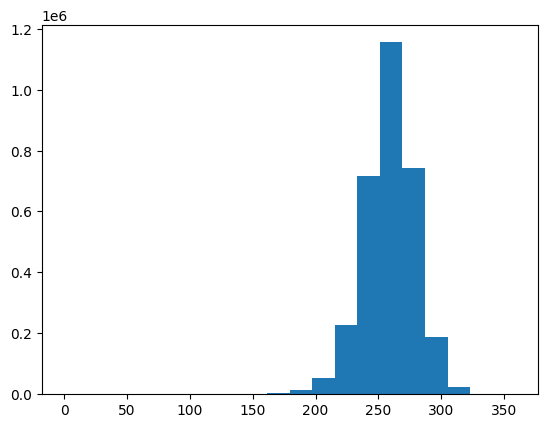

In [17]:
plt.hist(euc_list, bins=20)

In [26]:
np.quantile(euc_list, 0.01)

203.37867736816406

In [32]:
len(euc_list) * 0.01

31275.920000000002

(array([  1.,   1.,   3.,   0.,   9., 111., 520., 876., 229.,  18.]),
 array([118.81262207, 138.94992981, 159.08723755, 179.22454529,
        199.36185303, 219.49916077, 239.63646851, 259.77377625,
        279.91108398, 300.04839172, 320.18569946]),
 <BarContainer object of 10 artists>)

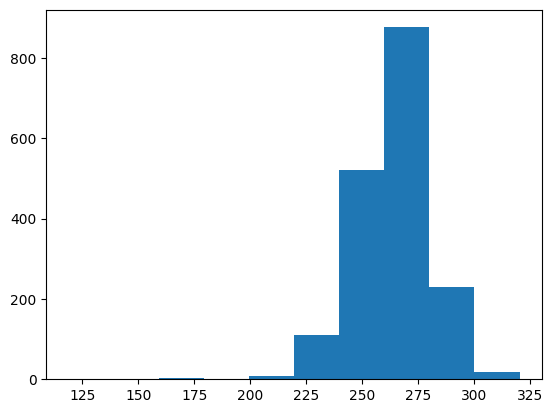

In [35]:
tmp_list = []
for j in range(len(q_ac_total)-1):
        tmp_list.append(euclidean_distance(q_h_total[0], q_h_total[j+1]).item())
plt.hist(tmp_list)